In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/My\ Drive/Colab\ Notebooks

/content/drive/My Drive/Colab Notebooks


In [3]:
import pandas as pd
import keras
import os
import numpy as np
from sklearn.metrics import log_loss
from keras import Model,Sequential
from keras.layers import *
from keras.optimizers import *
from sklearn.model_selection import train_test_split
import cv2
from tqdm.notebook import tqdm
import glob
from keras.layers import TimeDistributed, GRU, Dense, Dropout,LeakyReLU
import numpy as np
import pandas as pd
import cv2
import os
import json

In [4]:
        basedir = "./LRCN_dataset1"
        print(os.path.isdir(basedir))
        all_metadata_filenames = []
        all_video_filenames = []
        for dirpath, _, filenames in os.walk(basedir):
            for filename in filenames:
                if filename.endswith(".json"):
                    all_metadata_filenames.append(os.path.join(dirpath, filename).replace("\\","/"))
                elif filename.endswith(".jpg"):
                    all_video_filenames.append(os.path.join(dirpath, filename).replace("\\","/"))      

True


In [5]:
        metadata = {}
        for cur_metadata_filename in all_metadata_filenames:
            with open(cur_metadata_filename) as f_in:
                cur_metadata = json.load(f_in)
                for cur_key in cur_metadata:
                    # Store expanded versions of paths of videos in metadata
                    full_filename = os.path.join(os.path.dirname(cur_metadata_filename), cur_key.replace('.mp4','.jpg')).replace("\\","/")
                    metadata[full_filename] = {'label': cur_metadata[cur_key]['label']}
                    if 'original' in cur_metadata[cur_key] and cur_metadata[cur_key]['original']:
                        full_orig_filename = os.path.join(os.path.dirname(cur_metadata_filename), cur_metadata[cur_key]['original'].replace('.mp4','.jpg')).replace("\\","/")
                        metadata[full_filename]['original'] = full_orig_filename

In [7]:
        real_videos = []
        fake_videos = []
        for cur_video_filename in all_video_filenames:
            if metadata[cur_video_filename]['label'] == "FAKE":
                fake_videos.append(cur_video_filename)
            elif metadata[cur_video_filename]['label'] == "REAL":
                real_videos.append(cur_video_filename)
        # Sort the pathnames since consecutive runs of os.walk aren't guaranteed
        # to return all the data in the same order
        real_videos.sort()
        fake_videos.sort()

In [ ]:
print(len(real_videos))
print(len(fake_videos))

In [9]:
import cv2
import glob
import random
paths,Y=[],[]
fake=random.sample(fake_videos,2400)
#real_videos=real_videos[:1200]
#fake=fake[:1600]
for x in real_videos:
    paths.append(x)
    Y.append(0)
for x in fake:
    paths.append(x)
    Y.append(1)

In [10]:
def shuffle(X,y):
    new_train=[]
    for m,n in zip(X,y):
        new_train.append([m,n])
    random.shuffle(new_train)
    X,y=[],[]
    for x in new_train:
        X.append(x[0])
        y.append(x[1])
    return X,y

In [11]:
paths,y=shuffle(paths,Y)

In [12]:
def get_birghtness(img):
    return img/img.max()

In [13]:
from PIL import Image 
def process_img(img):
    imgs=[]
    
    for x in range(10):
        imgs.append(get_birghtness(img[:,x*256:(x+1)*256,:]))
    return np.array(imgs)

In [14]:

def gets(paths):
    al=[]
    for x in paths:
        img=cv2.cvtColor(cv2.imread(x),cv2.COLOR_BGR2RGB)
        img=cv2.resize(img,(2560,256))
        al.append(process_img(img))
    return al
def generator(paths,y,batch_size=16):
    while True:
        for x in range(len(paths)//batch_size):
            if x*batch_size+batch_size>len(paths):
                yield np.array(gets(paths[x*batch_size:])),np.array(y[x*batch_size:])
            yield np.array(gets(paths[x*batch_size:x*batch_size+batch_size])),np.array(y[x*batch_size:x*batch_size+batch_size])

In [15]:
from keras import backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))




In [16]:
import tensorflow as tf
def precision_fake(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives +K.epsilon())
        return precision
def recall_fake(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(1.0*y_true, 0, 1)))
        recall = true_positives / (possible_positives +K.epsilon())
        return recall   
def precision_real(y_true, y_pred):
        true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
        predicted_negatives = K.sum(K.round(K.clip((1-y_pred), 0, 1)))
        precision = true_negatives / (predicted_negatives+K.epsilon() )
        return precision
def recall_real(y_true, y_pred):
        true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
        possible_negatives = K.sum(K.round(K.clip(1.0-y_true, 0, 1)))
        recall = true_negatives / (possible_negatives + K.epsilon())
        return recall                
def F1_fake(y_true, y_pred):
  precision = precision_fake(y_true, y_pred)
  recall = recall_fake(y_true, y_pred)
  return 2*((precision*recall)/(precision+recall+K.epsilon()))   
def F1_real(y_true, y_pred):
  precision = precision_real(y_true, y_pred)
  recall = recall_real(y_true, y_pred)
  return 2*((precision*recall)/(precision+recall+K.epsilon()))    
def Macro_f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    # tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)  

In [17]:
def InceptionLayer(a, b, c, d):
    def func(x):
        x1 = Conv2D(a, (1, 1), padding='same', activation='elu')(x)
        
        x2 = Conv2D(b, (1, 1), padding='same', activation='elu')(x)
        x2 = Conv2D(b, (3, 3), padding='same', activation='elu')(x2)
            
        x3 = Conv2D(c, (1, 1), padding='same', activation='elu')(x)
        x3 = Conv2D(c, (3, 3), dilation_rate = 2, strides = 1, padding='same', activation='elu')(x3)
        
        x4 = Conv2D(d, (1, 1), padding='same', activation='elu')(x)
        x4 = Conv2D(d, (3, 3), dilation_rate = 3, strides = 1, padding='same', activation='elu')(x4)
        y = Concatenate(axis = -1)([x1, x2, x3, x4])
            
        return y
    return func

In [19]:
def define_model(shape=(256,256,3)):
    x = Input(shape = shape)
    
    x1 = InceptionLayer(1, 4, 4, 2)(x)
    x1 = BatchNormalization()(x1)
    x1 = MaxPooling2D(pool_size=(2, 2), padding='same')(x1)
    
    x2 = InceptionLayer(2, 4, 4, 2)(x1)
    x2 = BatchNormalization()(x2)        
    x2 = MaxPooling2D(pool_size=(2, 2), padding='same')(x2)        
        
    x3 = Conv2D(16, (5, 5), padding='same', activation = 'elu')(x2)
    x3 = BatchNormalization()(x3)
    x3 = MaxPooling2D(pool_size=(2, 2), padding='same')(x3)
        
    x4 = Conv2D(16, (5, 5), padding='same', activation = 'elu')(x3)
    x4 = BatchNormalization()(x4)
    
    x4 = MaxPooling2D(pool_size=(4, 4), padding='same')(x4)
    
    y = Flatten()(x4)
    y = Dropout(0.5)(y)
    y = Dense(16)(y)
    y = LeakyReLU(alpha=0.1)(y)
    y = Dropout(0.5)(y)
    y = Dense(1, activation = 'sigmoid')(y)
    model=Model(inputs = x, outputs = y)
    model.compile(loss='binary_crossentropy',optimizer=Adam(lr=1e-4))
    #model.summary()
    return model

In [20]:
model3=define_model()
model3.load_weights('./MesoInception_F2F')

In [21]:
def build_convnet(shape):
    x = Input(shape = shape)
    
    x1 = InceptionLayer(1, 4, 4, 2)(x)
    x1 = BatchNormalization()(x1)
    x1 = MaxPooling2D(pool_size=(2, 2), padding='same')(x1)
    
    x2 = InceptionLayer(2, 4, 4, 2)(x1)
    x2 = BatchNormalization()(x2)        
    x2 = MaxPooling2D(pool_size=(2, 2), padding='same')(x2)        
        
    x3 = Conv2D(16, (5, 5), padding='same', activation = 'elu')(x2)
    x3 = BatchNormalization()(x3)
    x3 = MaxPooling2D(pool_size=(2, 2), padding='same')(x3)
        
    x4 = Conv2D(16, (5, 5), padding='same', activation = 'elu')(x3)
    x4 = BatchNormalization()(x4)
   
    x4 = MaxPooling2D(pool_size=(4, 4), padding='same')(x4)
    y = Flatten()(x4)
   
#     print(x4.shape)    
#     #y = Flatten()(x4)
#     x4 = Reshape((32,32))(x4)
#     y = LSTM(2048, return_sequences=False)(x4)
#     y = Dropout(0.5)(y)
#     y = Dense(16)(y)
#     y = LeakyReLU(alpha=0.1)(y)
#     y = Dropout(0.5)(y)
#     y = Dense(1, activation = 'sigmoid')(y)
    model=Model(inputs = x, outputs = y)
    #model.compile(loss='binary_crossentropy',optimizer=Adam(lr=1e-4))
    #model.summary()
    return model

In [22]:
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint
X_train, X_test, y_train, y_test=train_test_split(paths,y,test_size=0.25,random_state=9)
print(X_train[0])
img=cv2.cvtColor(cv2.imread(X_train[0]),cv2.COLOR_BGR2RGB)
img=cv2.resize(img,(2560,256))
o=process_img(img)
print(o.shape)

./LRCN_dataset1/DeepFake04/zuduhdfojh.jpg
(10, 256, 256, 3)


In [23]:
print(len(y_test))
j=0
for i in range(len(y_test)):
  if y_test[i] == 0 : j=j+1
print(j)  
print(1084-j)
num_real=j
num_fake=1084-j

1084
471
613


In [29]:
    n_frames=10
    shape1 = (256, 256)
    shape=(10,256,256,3)
    convnet = build_convnet(shape[1:])
    #print(len(convnet.layers))
    for new_layer, layer in zip(convnet.layers, model3.layers):
            new_layer.set_weights(layer.get_weights())
    #convnet.load_weights('./MesoInception_F2F',by_name=True)
    #convnet.summary()
    for layer in convnet.layers:
        layer.trainable = False
    weights_list = convnet.get_weights()
    wt1=model3.get_weights()

In [30]:
convnet.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_49 (Conv2D)              (None, 256, 256, 4)  16          input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_51 (Conv2D)              (None, 256, 256, 4)  16          input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_53 (Conv2D)              (None, 256, 256, 2)  8           input_4[0][0]                    
_______________________________________________________________________________________

In [41]:
bottleneck=convnet
inp=Input((10,256,256,3))
from keras.layers import *
x=TimeDistributed(bottleneck)(inp)
x = LSTM(128)(x)
x = Dense(64, activation='elu')(x)
x = Dense(1,activation='sigmoid')(x)

In [42]:
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint
X_train, X_test, y_train, y_test=train_test_split(paths,y,test_size=0.25)
from keras import Model
model=Model(inp,x)
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
def schedule(epoch):
    return [6e-4,1e-4][epoch]
callback=LearningRateScheduler(schedule)
model.compile(loss='binary_crossentropy',optimizer=Adam(lr=1e-4),metrics=['accuracy',f1,precision_real,precision_fake,recall_real,recall_fake,F1_real,F1_fake])
#model.fit(X,y,batch_size=16)
filepath = "./superbmeso.h5"
checkpoint=ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]


In [43]:
print(X_train[0])
img=cv2.cvtColor(cv2.imread(X_train[0]),cv2.COLOR_BGR2RGB)
img=cv2.resize(img,(2560,256))
o=process_img(img)
print(o.shape)

./LRCN_dataset1/DeepFake02/krjxsqhshk.jpg
(10, 256, 256, 3)


In [44]:
print(len(X_train))
print(len(X_test))

3252
1084


In [45]:
history = model.fit(generator(X_train,y_train,8),steps_per_epoch=len(X_train)//8+1,validation_data=generator(X_test,y_test,8),validation_steps=len(X_test)//8+1,epochs=20,callbacks=callbacks_list)

Epoch 1/20
407/407 [==============================] - ETA: 0s - loss: 0.6498 - accuracy: 0.6265 - f1: 0.6613 - precision_real: 0.5213 - precision_fake: 0.6418 - recall_real: 0.4357 - recall_fake: 0.7546 - F1_real: 0.4367 - F1_fake: 0.6613
Epoch 00001: loss improved from inf to 0.64983, saving model to ./superbmeso.h5
407/407 [==============================] - 125s 307ms/step - loss: 0.6498 - accuracy: 0.6265 - f1: 0.6613 - precision_real: 0.5213 - precision_fake: 0.6418 - recall_real: 0.4357 - recall_fake: 0.7546 - F1_real: 0.4367 - F1_fake: 0.6613 - val_loss: 0.6163 - val_accuracy: 0.6903 - val_f1: 0.6997 - val_precision_real: 0.6622 - val_precision_fake: 0.7099 - val_recall_real: 0.6382 - val_recall_fake: 0.7382 - val_F1_real: 0.6176 - val_F1_fake: 0.6997
Epoch 2/20
407/407 [==============================] - ETA: 0s - loss: 0.5983 - accuracy: 0.6824 - f1: 0.6953 - precision_real: 0.6545 - precision_fake: 0.6952 - recall_real: 0.5732 - recall_fake: 0.7593 - F1_real: 0.5685 - F1_fake: 

dict_keys(['loss', 'accuracy', 'f1', 'precision_real', 'precision_fake', 'recall_real', 'recall_fake', 'F1_real', 'F1_fake', 'val_loss', 'val_accuracy', 'val_f1', 'val_precision_real', 'val_precision_fake', 'val_recall_real', 'val_recall_fake', 'val_F1_real', 'val_F1_fake'])


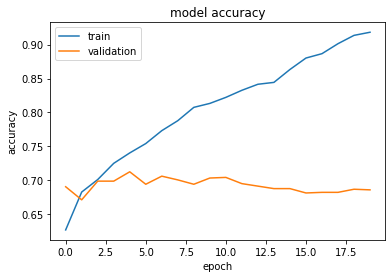

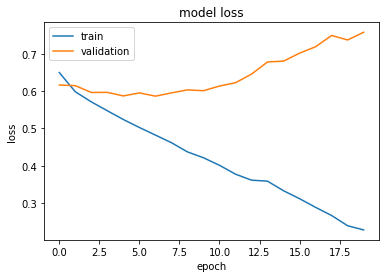

In [46]:
print(history.history.keys())
#  "Accuracy"
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

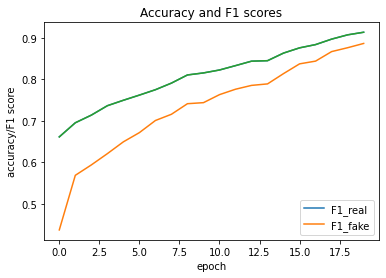

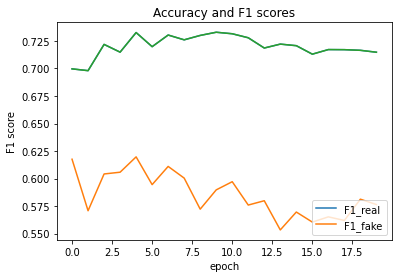

In [47]:
import matplotlib.pyplot as plt

plt.plot(history.history['f1'])
plt.plot(history.history['F1_real'])
plt.plot(history.history['F1_fake'])

plt.title('Accuracy and F1 scores')
plt.ylabel('accuracy/F1 score')
plt.xlabel('epoch')
plt.legend([ 'F1_real','F1_fake'], loc='lower right')
plt.show()
# "Loss"

plt.plot(history.history['val_f1'])
plt.plot(history.history['val_F1_real'])
plt.plot(history.history['val_F1_fake'])
plt.title('Accuracy and F1 scores')
plt.ylabel('F1 score')
plt.xlabel('epoch')
plt.legend([ 'F1_real','F1_fake'], loc='lower right')
plt.show()

dict_keys(['loss', 'accuracy', 'f1', 'precision_real', 'precision_fake', 'recall_real', 'recall_fake', 'F1_real', 'F1_fake', 'val_loss', 'val_accuracy', 'val_f1', 'val_precision_real', 'val_precision_fake', 'val_recall_real', 'val_recall_fake', 'val_F1_real', 'val_F1_fake'])


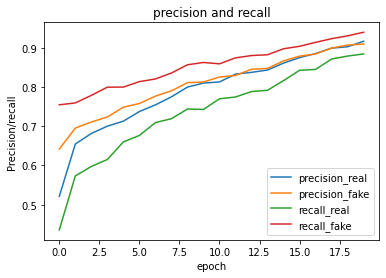

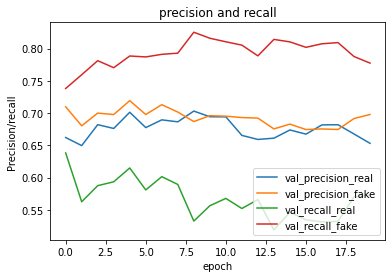

In [48]:
print(history.history.keys())
#  "Accuracy"
import matplotlib.pyplot as plt


plt.plot(history.history['precision_real'])
plt.plot(history.history['precision_fake'])
plt.plot(history.history['recall_real'])
plt.plot(history.history['recall_fake'])

plt.title('precision and recall')
plt.ylabel('Precision/recall')
plt.xlabel('epoch')
plt.legend(['precision_real','precision_fake','recall_real','recall_fake'], loc='lower right')
plt.show()
# "Loss"


plt.plot(history.history['val_precision_real'])
plt.plot(history.history['val_precision_fake'])
plt.plot(history.history['val_recall_real'])
plt.plot(history.history['val_recall_fake'])

plt.title('precision and recall')
plt.ylabel('Precision/recall')
plt.xlabel('epoch')
plt.legend(['val_precision_real','val_precision_fake','val_recall_real','val_recall_fake'], loc='lower right')
plt.show()

dict_keys(['loss', 'accuracy', 'f1', 'precision_real', 'precision_fake', 'recall_real', 'recall_fake', 'F1_real', 'F1_fake', 'val_loss', 'val_accuracy', 'val_f1', 'val_precision_real', 'val_precision_fake', 'val_recall_real', 'val_recall_fake', 'val_F1_real', 'val_F1_fake'])


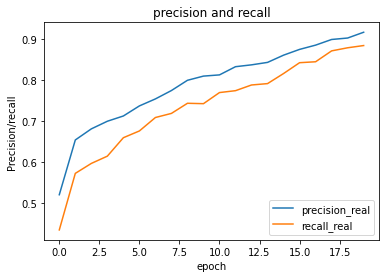

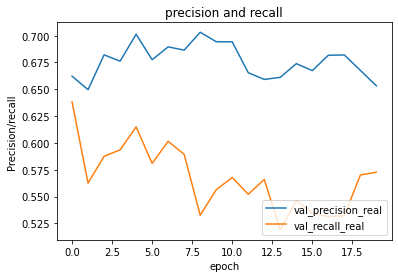

In [49]:
print(history.history.keys())
#  "Accuracy"
import matplotlib.pyplot as plt


plt.plot(history.history['precision_real'])

plt.plot(history.history['recall_real'])


plt.title('precision and recall')
plt.ylabel('Precision/recall')
plt.xlabel('epoch')
plt.legend(['precision_real','recall_real'], loc='lower right')
plt.show()
# "Loss"


plt.plot(history.history['val_precision_real'])

plt.plot(history.history['val_recall_real'])


plt.title('precision and recall')
plt.ylabel('Precision/recall')
plt.xlabel('epoch')
plt.legend(['val_precision_real','val_recall_real'], loc='lower right')
plt.show()

dict_keys(['loss', 'accuracy', 'f1', 'precision_real', 'precision_fake', 'recall_real', 'recall_fake', 'F1_real', 'F1_fake', 'val_loss', 'val_accuracy', 'val_f1', 'val_precision_real', 'val_precision_fake', 'val_recall_real', 'val_recall_fake', 'val_F1_real', 'val_F1_fake'])


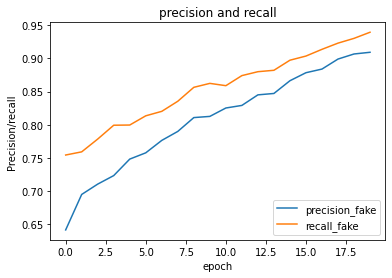

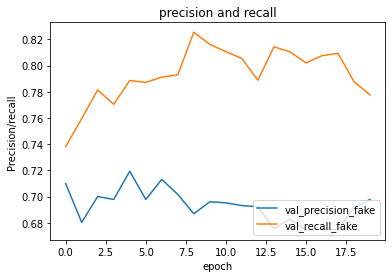

In [50]:
print(history.history.keys())
#  "Accuracy"
import matplotlib.pyplot as plt



plt.plot(history.history['precision_fake'])

plt.plot(history.history['recall_fake'])

plt.title('precision and recall')
plt.ylabel('Precision/recall')
plt.xlabel('epoch')
plt.legend(['precision_fake','recall_fake'], loc='lower right')
plt.show()
# "Loss"



plt.plot(history.history['val_precision_fake'])

plt.plot(history.history['val_recall_fake'])

plt.title('precision and recall')
plt.ylabel('Precision/recall')
plt.xlabel('epoch')
plt.legend(['val_precision_fake','val_recall_fake'], loc='lower right')
plt.show()

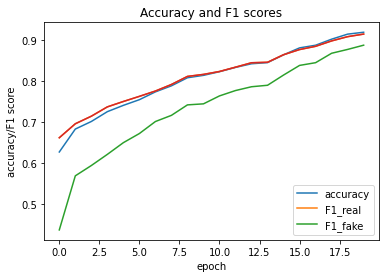

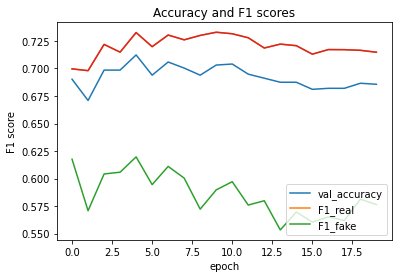

In [51]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['f1'])
plt.plot(history.history['F1_real'])
plt.plot(history.history['F1_fake'])

plt.title('Accuracy and F1 scores')
plt.ylabel('accuracy/F1 score')
plt.xlabel('epoch')
plt.legend(['accuracy', 'F1_real','F1_fake'], loc='lower right')
plt.show()
# "Loss"
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['val_f1'])
plt.plot(history.history['val_F1_real'])
plt.plot(history.history['val_F1_fake'])
plt.title('Accuracy and F1 scores')
plt.ylabel('F1 score')
plt.xlabel('epoch')
plt.legend(['val_accuracy', 'F1_real','F1_fake'], loc='lower right')
plt.show()

dict_keys(['loss', 'accuracy', 'f1', 'precision_real', 'precision_fake', 'recall_real', 'recall_fake', 'F1_real', 'F1_fake', 'val_loss', 'val_accuracy', 'val_f1', 'val_precision_real', 'val_precision_fake', 'val_recall_real', 'val_recall_fake', 'val_F1_real', 'val_F1_fake'])


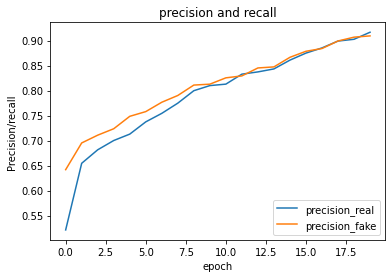

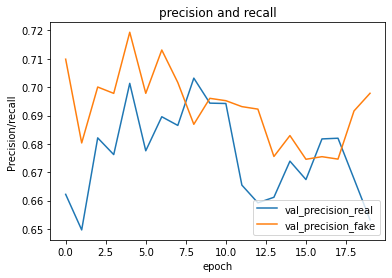

In [52]:
print(history.history.keys())
#  "Accuracy"
import matplotlib.pyplot as plt


plt.plot(history.history['precision_real'])
plt.plot(history.history['precision_fake'])


plt.title('precision and recall')
plt.ylabel('Precision/recall')
plt.xlabel('epoch')
plt.legend(['precision_real','precision_fake'], loc='lower right')
plt.show()
# "Loss"


plt.plot(history.history['val_precision_real'])
plt.plot(history.history['val_precision_fake'])


plt.title('precision and recall')
plt.ylabel('Precision/recall')
plt.xlabel('epoch')
plt.legend(['val_precision_real','val_precision_fake'], loc='lower right')
plt.show()

dict_keys(['loss', 'accuracy', 'f1', 'precision_real', 'precision_fake', 'recall_real', 'recall_fake', 'F1_real', 'F1_fake', 'val_loss', 'val_accuracy', 'val_f1', 'val_precision_real', 'val_precision_fake', 'val_recall_real', 'val_recall_fake', 'val_F1_real', 'val_F1_fake'])


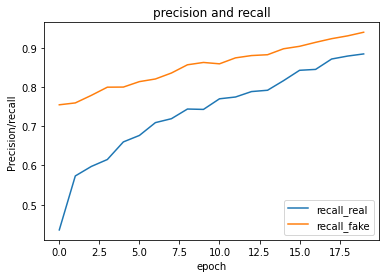

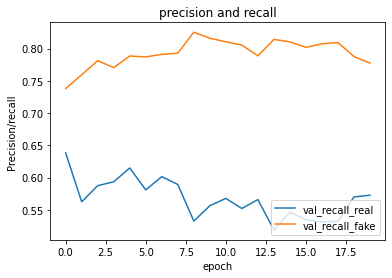

In [53]:
print(history.history.keys())
#  "Accuracy"
import matplotlib.pyplot as plt



plt.plot(history.history['recall_real'])
plt.plot(history.history['recall_fake'])

plt.title('precision and recall')
plt.ylabel('Precision/recall')
plt.xlabel('epoch')
plt.legend(['recall_real','recall_fake'], loc='lower right')
plt.show()
# "Loss"



plt.plot(history.history['val_recall_real'])
plt.plot(history.history['val_recall_fake'])

plt.title('precision and recall')
plt.ylabel('Precision/recall')
plt.xlabel('epoch')
plt.legend(['val_recall_real','val_recall_fake'], loc='lower right')
plt.show()

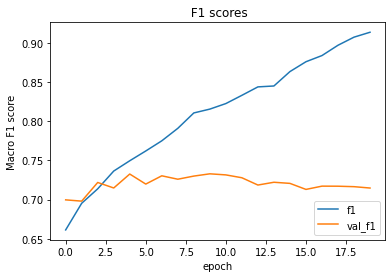

In [54]:
plt.plot(history.history['f1'])
plt.plot(history.history['val_f1'])
plt.title(' F1 scores')
plt.ylabel('Macro F1 score')
plt.xlabel('epoch')
plt.legend(['f1','val_f1'], loc='lower right')
plt.show()

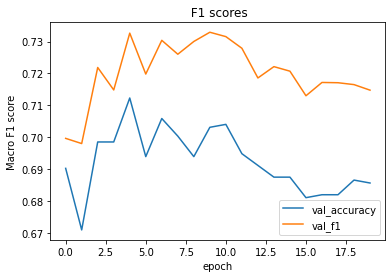

In [55]:
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['val_f1'])

plt.title(' F1 scores')
plt.ylabel('Macro F1 score')
plt.xlabel('epoch')
plt.legend(['val_accuracy','val_f1'], loc='lower right')
plt.show()